# Replication Michael P. Keane & Kenneth I. Wopin

This notebook replicates results from: 

Keane, M. P. & Wopin, W. I. (1997). [The career Decisions of Young Men.](https://www.jstor.org/stable/10.1086/262080)
 *Journal of Political Economy, 105(3): 473-552.*

The above mentioned paper builds on the theoratical paper from:

Keane, M. P. & Wopin, W. I., & Vytlacil, E. J. (1994). 
[The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence.](https://www.jstor.org/stable/2109768)
 *The Review of Economics and Statistics, 76(4): 648-672.*

For this purpose l rely on the  *respy* and *estimagic* open-source python packages. [*Respy*](https://github.com/OpenSourceEconomics/respy) is for the simulation and estimation of a prototypical finite-horizon discrete choice dynamic programming model and [*Estimagic*](https://github.com/OpenSourceEconomics/estimagic) helps to build high-quality and user friendly implementations of (structural) econometric models.

In **section 1**, l give an introduction to the project, my motivation for replicating KW1997 as well what motivates the paper. I replicate the descriptive statistics of the data and illustrate them graphically in **section 2**. It should be kept in mind whilst interpreting the graphs, that as the number of periods increase, sample attrition plays a role. In **section 3**, l discuss the theoretical framework of the paper, which ties back to the descriptive statistics in section 2, as well as develop a causal graphical framework for the model.  I then reproduce the main results in **section 4** using the *respy* and *estimagic* packages and calculate standard errors for the estimated parameters. In **section 5**, l discuss the results of the paper and my thoughts on some avenues for possible extension which in turn concludes my contribution to the replication of KW1997.

# Section 1: Background

#### Motivation for replicating KW1997

Often times, the research outcomes that emerge from data in the developed world's context do not easily replicate in a developing country setting. However, many lessons could be drawn from them to learn something about human capital formation for low income countries (LICs). I chose to replicate this paper to learn more about structural econometric methods in a human capital formation setting. I hope to apply my knowledge to address questions, in the future, such as how to increase the level of skill acquired in the higher education system such that the up and coming generation of the African workforce is well equipped for competent roles in the labor market. Ultimately, this could inform policy to help achieve the African Union's 2063 vision - to build an integrated, prosperous and peaceful Africa, driven by its own citizens.

#### Groundwork 

This project builds upon collaboration and contributions to the *respy* and *estimagic* open source packages. In particular, l have worked with some of the open source contributors of these packages to develop parts of the code.

For the *respy* package, l have integrated the results of a project l previously completed on [benchmarking various implementations of ols and iv ](https://github.com/lindamaok899/least_squares). This was done to drop all statsmodels dependencies in the package in favor of incorporating a faster method of calculating ols estimates. I have also integrated a root mean squared error (rmse) function in the package for the same purpose.

For the *estimagic* package, l have worked on the documentation of the numerical optimizers used in the package. In particular, l have created reference dictionaries for the different arguments that relate to the various implemented numerical optimizers.

For both packages and an additional project (*uncertainty quantification project*), l write functions that construct the full covariance matrix of the estimated parameters of maximum likelihood models. There are different ways to calculate those covariance matrices, but in all cases they are based on derivatives of the log likelihood function. I have also written a function that extracts the diagonal elements of these covariance matrices to construct a 1d array containing the standard errors, both of which could be found in [this](https://github.com/OpenSourceEconomics/estimagic/blob/likelihood_inference/estimagic/inference/likelihood_covs.py) module. To ensure integrity of the functions, l have written a benchmarking module that compares the functions to the statsmodels output which can be found [here](https://github.com/lindamaok899/standard_errors/blob/master/code/benchmark_results.py). Lastly, l have written [tests](https://github.com/OpenSourceEconomics/estimagic/blob/likelihood_inference/estimagic/tests/inference/test_likelihood_covs.py) for all the maximum likelihood covariance matrix functions.


#### Authors' motivation

This paper provides structural estimates of schooling, work and occupational choice decisions based on 11 years of observations on a sample of 1373 white young men from the 1979 youth cohort of the National Longitudinal Surveys of Labor Market Experience (NLSY). The authors ingeminate the importance of incorporating self selection for an accurate assessment of the differential productivity of human capital investment. In their paper, they extend earlier (prior to 1997) work done in the this field by considering self-selection in the three dimensions of schooling, work and occupational choice. More specifically, they extend the static deterministic setting of earlier models (Heckman and Sedlacek, 1985; Willis, 1986), each of which is an extension of the basic Roy (1951) framework, to a model in which decision making is sequential and the environment is uncertain.

The structural approach in Keane and Wopin (1997) provides rigorous interpretations for the parameters that are estimated, which has several important implications for ex-ante policy evaluation such as:

1) predicting the effect an intervention that provides college tuition subsidies has on college attendance rates and subsequent occupational choice decisions

2) assessing the welfare effects of interventions on lifetime wealth and utility, allowing policy makers to draw distributional consequences of them 

To implement the model, the participants are assigned in each year to one of five discrete, mutually exclusive alternatives: attending school, working in a white collar occupation, working in a blue collar occupation, working in the military or engaging on home production.

# Section 2: Data & Visualisation

#### Data loading and processing

First, l import the necessary packages.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from auxiliary.auxiliary import *
import warnings

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('ticks')

warnings.filterwarnings(action='once')

I then conduct some basic data preparation and pre-processing to increase readability.

In [3]:
# Ensure proper formatting of the wage variable
pd.options.display.float_format = '{:,.2f}'.format

# Label and format the different columns
columns = ['Identifier', 'Age', 'Schooling', 'Choice', 'Wage']
dtype = {'Identifier': np.int, 'Age': np.int,  'Schooling': np.int,  'Choice': 'category'}

# Read the original data file
df = pd.DataFrame(np.genfromtxt('data/KW_97.raw'), columns=columns).astype(dtype)

# Label the different choice categories
df['Choice'].cat.categories = ['Schooling', 'Home', 'White', 'Blue', 'Military']

# Set the index for easier interpretability
df['Period'] = df['Age'] - 16
df.set_index(['Identifier', 'Period'], inplace=True, drop=True)

#### Data description

All individuals enter the model initially at the same age and are then observed for a varying number of consecutive years. Each year, the individual's decision to work in either a white or blue collar occupation, attend school, enroll in the military, or remain at home is recorded. If the individual is working, the dataset potentially also contains that year's wage as a full-time equivalent. As can be seen from the replication of table 1 below, there is considerable missing wage information, particularly at the younger ages and for blue collar employment.

In [4]:
# preview the data
df.head()

Age  Schooling     Choice  Wage
Identifier Period                                 
6          0        16         11  Schooling   nan
           1        17         12  Schooling   nan
           2        18         13  Schooling   nan
           3        19         14  Schooling   nan
           4        20         15  Schooling   nan

In [5]:
df_unindexed = df.reset_index().rename(columns={0:'value'})
df_unindexed.head()

,Identifier,Period,Age,Schooling,Choice,Wage
0,6,0,16,11,Schooling,nan
1,6,1,17,12,Schooling,nan
2,6,2,18,13,Schooling,nan
3,6,3,19,14,Schooling,nan
4,6,4,20,15,Schooling,nan


#### Sample size distribution by age

The sample size seems to decrease as the periods increase, most likely attributable to sample attrition.

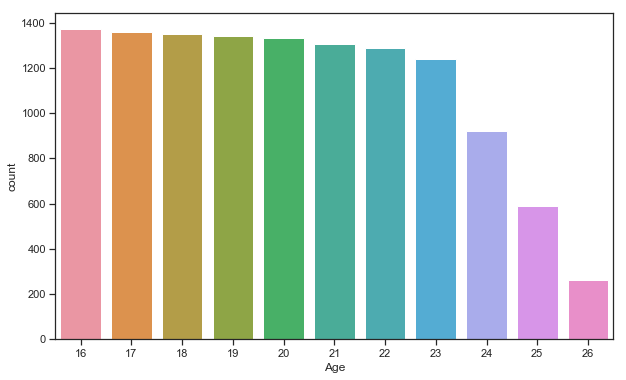

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(df['Age'])

##### Years of schooling in initial period
This plot illustrates the given level of schooling at age 16. barplot below illustrates that there is observed heterogeneity in school starting years with a number of people falling within the 10 and 11 year age range. It is plausible that the people with years of schooling below 10 years may have dropped out of school, whilst the ones above 11 years could be as a result of a data anomaly.

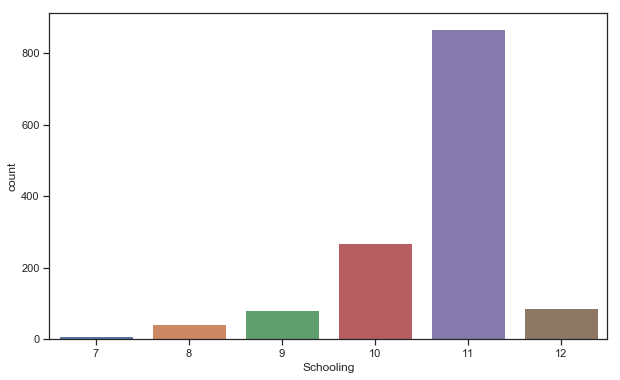

In [30]:
initial_schooling(df_unindexed)

#### Wages

The figures below show that occupation-specific wage is increasing in age and years of experience. Returns to schooling are larger in white-collar jobs. While the initial wage is lower, it does increase rapidly with schooling compared as compared to the blue-collar professions.

##### Average real wage by occupation as in Table 4
The table shows age-specific average real wages overall and by occupation. White- and blue-collar occupations are very similar through age 21. However, after this age, white-collar wages are, on average, about 20 percent higher. Military ages are the lowest at all ages. 

In [1]:
tab = pd.crosstab(index=df['Age'], columns=df['Choice'], values=df['Wage'], aggfunc='mean', margins=True)
tab[['All', 'White', 'Blue', 'Military']]

NameError: name 'df' is not defined

We see in the plot below that occupational choices exhibit persistence.

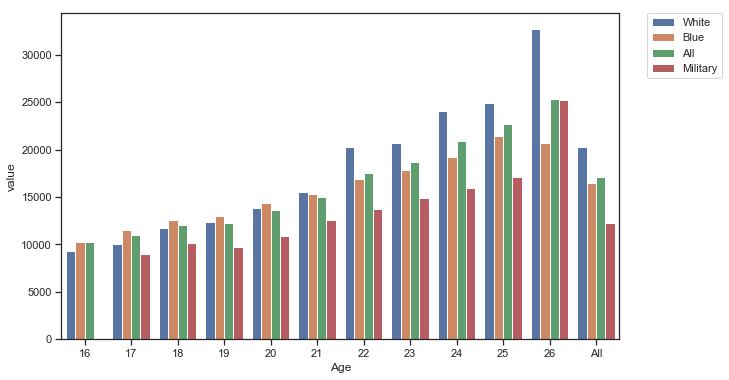

In [32]:
occupational_choice(tab)

##### Real wage per period within the choice set

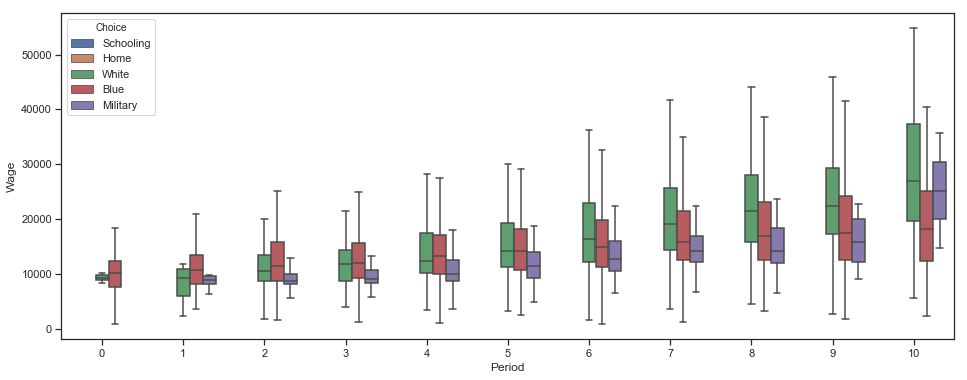

In [33]:
real_wage(df_unindexed)

##### Relationship between wage and years of schooling

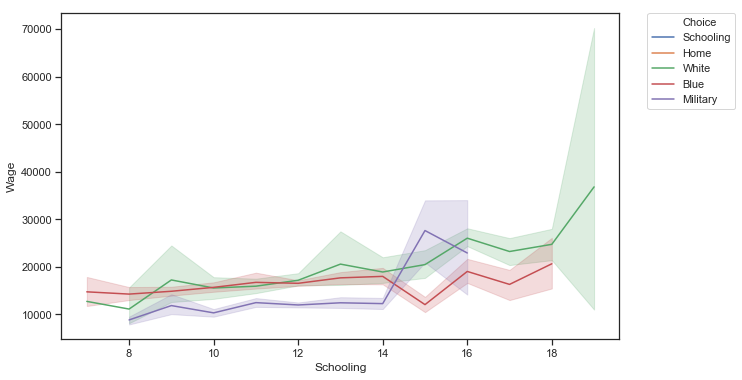

In [34]:
wage_schooling(df)

#### Choice

This part shows graphically, different attributes of the choices to illustrate the variables in the dataset.

The figures below illustrate that (i) school attendance should decline with age, and that (ii) employment should increase with age. We see that participation in both white- and blue-collar occupations increase monotonically, but at different rates. What is noteworthy is that participation in blue-collar occupations is essentially unchanged after age 22, whereas white collar participation almost doubles between ages 22 and 25. It is evident from the graphs, that there is a close connection between leaving school at college-going ages and moving into white-collar employment. In contrast to civilian occupations, participating in the military quickly increases to a peak at age 20, then declines at about age 25.

##### Number of individuals per choice

In [2]:
sns.countplot(df['Choice'])
plt.show()

NameError: name 'sns' is not defined

##### Average age by choice

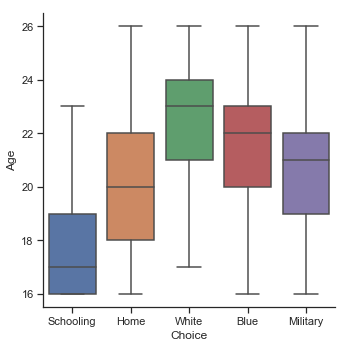

In [36]:
# Outliers excluded from this plot, to include them showfliers=True
sns.catplot(x="Choice", y="Age", kind="box", data=df, showfliers=False)
plt.show()

##### Average school attainment by choice

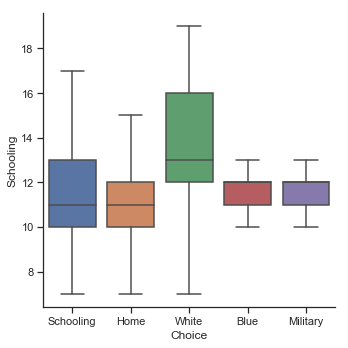

In [37]:
# outliers excluded in this plot, to include them showfliers=True
sns.catplot(x="Choice", y="Schooling", kind="box", data=df, showfliers=False)
plt.show()

##### Choice distribution by age as in Table 1
From the table below, we see that the vast majority of the sample, approximately 86%, is in school at age 16. 

In [38]:
table = pd.crosstab(index=df['Age'], columns=df['Choice'], margins=True)
table

Choice,Schooling,Home,White,Blue,Military,All
Age,,,,,,
16,1178,145,4,45,1,1373
17,1014,197,15,113,20,1359
18,561,296,92,331,70,1350
19,420,293,115,406,107,1341
20,341,273,149,454,113,1330
21,275,257,170,498,106,1306
22,169,212,256,559,90,1286
23,105,185,336,546,68,1240
24,65,112,284,416,44,921


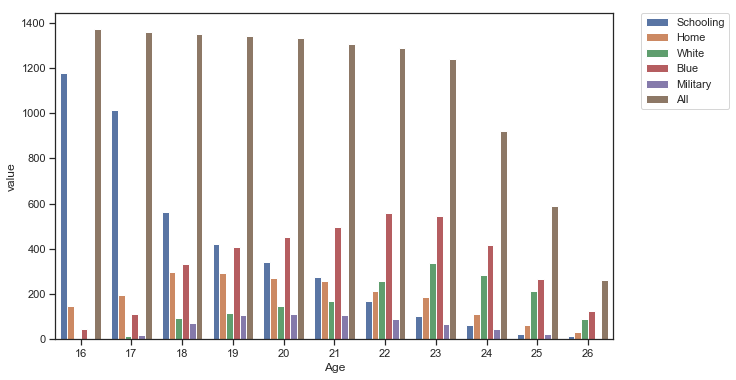

In [39]:
choice_dist(table)

##### Proportion of people choosing certain choices per period as in Table 3 (row 2)
These figures show the proportion choosing each choice from the choice set (unconditionally).

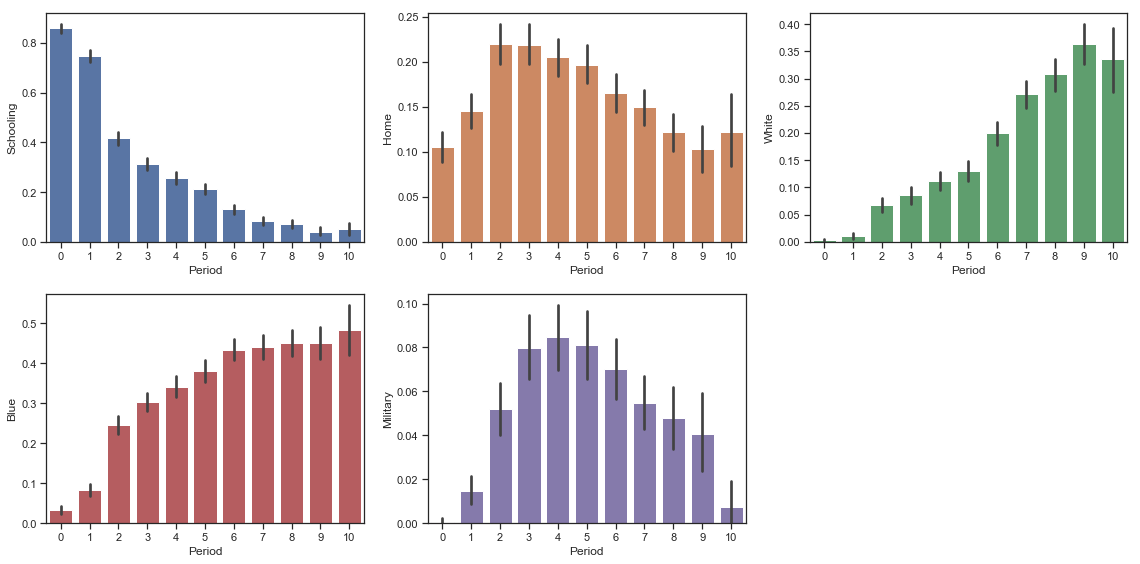

In [40]:
plot_bars(df_unindexed, ax)

#### Occupational transitions
Below, l replicate Table 2 in the paper that shows one period transition rates, illustrating persistence in choice over periods.
My reproduced results deviate in some rows/columns from the results in the paper. A plausible explanation would be that what l have done below ensures precision in calculation i.e normalizing row-wise) which may not have been the case when this paper was authored. Nonetheless, the results indicate the same as what has been documented in KW1997 with a few misaligned figures within the table.

In [42]:
data = df_unindexed.copy()
data['next_period'] = data['Period'] + 1
choice_data = df_unindexed[['Identifier', 'Period', 'Choice']]
choice_data.rename(columns={'Choice': 'NextChoice'}, inplace=True)

combined = pd.merge(
    left=data, 
    right=choice_data, 
    left_on=['Identifier', 'next_period'],
    right_on=['Identifier', 'Period'], 
    how='left', 
    suffixes=['', '_next'],
)
combined.drop(columns=['Period_next', 'next_period'], inplace=True)

# only first row is different from paper
tab_rows = (pd.crosstab(index=combined['Choice'], columns=combined['NextChoice'], normalize='index') * 100).round(1)

# all are different from paper because the normalization divides by sum over rows
tab_cols = (pd.crosstab(index=combined['Choice'], columns=combined['NextChoice'], normalize='columns') * 100).round(1)


# produces tables
# the first table (tab_rows) is the percentage of transitions from origin to destination i.e the row percentage
# the second table (tab_cols) is the percentage in a particular destination who started from each origin i.e column percentage
list_dfs = []
list_dfs.append( tab_rows )
list_dfs.append( tab_cols )
multi_column_df_display(list_dfs)

NextChoice,Schooling,Home,White,Blue,Military
Choice,,,,,
Schooling,64.50,13.00,8.60,12.10,1.80
Home,9.80,47.20,8.10,31.30,3.70
White,5.70,6.30,67.40,19.90,0.70
Blue,3.40,12.40,9.90,73.40,0.90
Military,1.40,5.50,3.10,9.60,80.40
NextChoice,Schooling,Home,White,Blue,Military
Choice,,,,,
Schooling,87.50,27.50,20.30,13.20,11.00
Home,6.10,46.10,8.80,15.80,10.70


The heatmaps below show considerable immobility out of the home alternative, with the indication that observations that begin at home are also at home in the next period. The heatmaps also show substantial state dependence in occupation-specific employment for example, a majority of the people who are employed in white-collar occupations in one period are in white-collar occupations in the next, and the reverse is also true. 

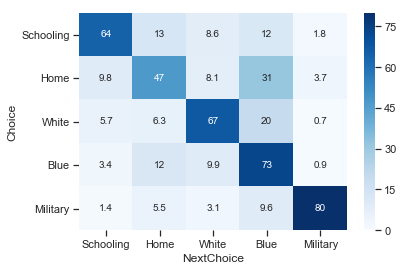

In [18]:
# this heatmap is the percentage of transitions from origin to destination i.e the row percentage
sns.heatmap(tab_rows, cmap='Blues', vmin=0, vmax=80, annot=True)
plt.show()

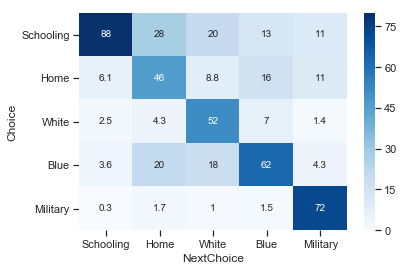

In [19]:
# the second table (tab_cols) is the percentage in a particular destination who started from each origin i.e column percentage
sns.heatmap(tab_cols, cmap='Blues', vmin=0, vmax=80, annot=True)
plt.show()

##### Age pattern of inter-occupational transitions (not shown in paper)
Here l illustrate with period-wise heatmaps that, the age pattern of inter-occupational transitions differs considerably. After age 21 for example, transitions from white- to blue-collar occupations drop considerably.  

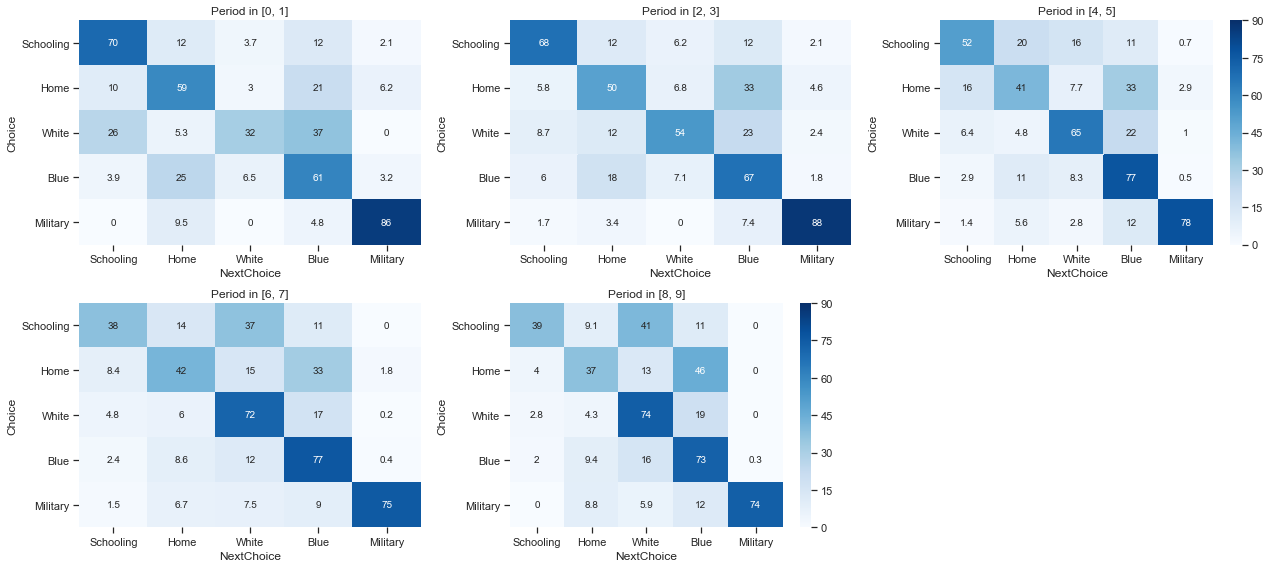

In [20]:
period_pairs_rows(combined)

The reverse transition, shown below, from white- to blue-collar jobs increases with age, supporting the notion from above.

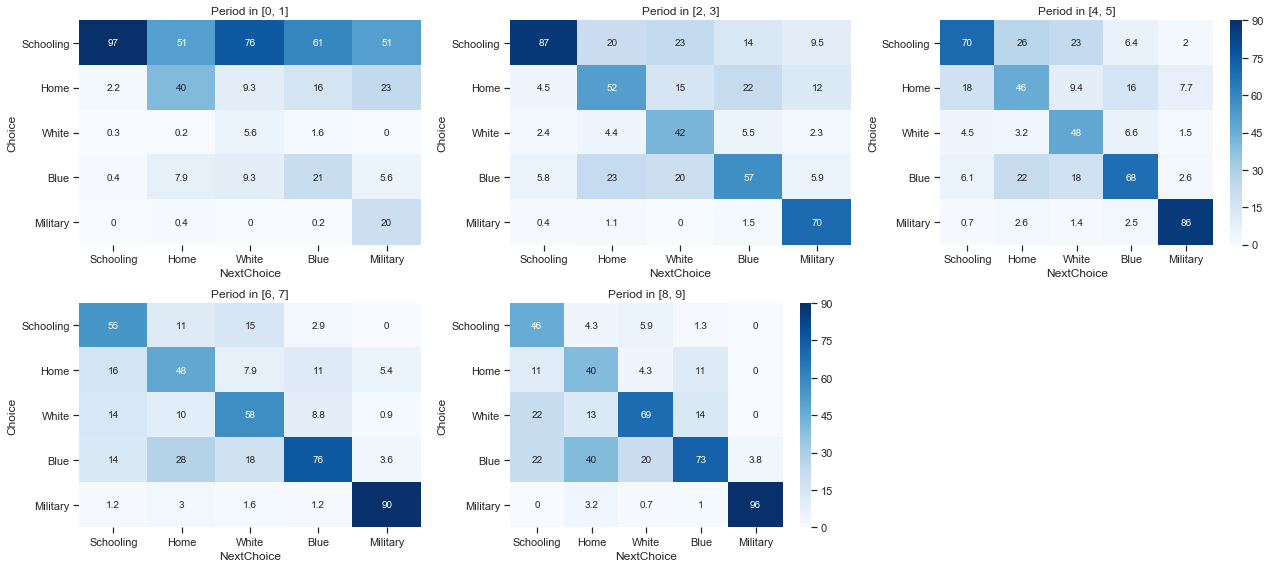

In [21]:
period_pairs_cols(combined)

## Section 3: Theoretical framework

The authors estimate a basic human capital model against the data descriptives presented in the previous section and a data simulation of 5,000 individuals to illustrate that the basic human capital model, overall, does not provide a good fit to capture the quantitative features of the NLSY data. 

#### Why is the basic human capital model not a good fit?

In assessing the basic model, the authors consider three criteria: (1) the reasonableness of the parameter values, (2) the within-sample fit, and (3) out-of-sample fit. The basic model seems to generate parameter values that are within reasonable ranges. KW1997 then use the simulated data to assess within-sample fit and report that thee occur some discrepancies (underestimation) with respect to the schooling, military and home alternatives, although the qualitative age patterns are replicated. The basic model does not capture well the persistence in choices that are observed in the replication of tables 2 and 3 above. The authors report the model as seemingly tracking more closely, the effects of occupation-specific work experience on choice as in table 3, except for understanding the impact of the first year of experience. The model predicts that the first year of white- (blue-) collar experience increases the probability of choosing the white- (blue-) collar alternative by 15(27) percentage points versus the 31- (37) percentage-point increase as shown in the heatmaps above. The basic model does not produce reasonable forecasts for the out-of-sample fit measure as well.

#### The extended model

The authors attempt to better fit the data by extending the basic human capital model in the direction motivated by the shortcomings of the basic model. The model extension serves to improve the overall distribution (replicated as table 1 above) and the pattern (replicated as table 2 and 3 above).



## Section 4: Replication of main result

#### Contribution to replicating KW1997

Here l make use of the functions l have written that calculate covariance matrices for hessian and jacobian matrices. These functions have since been encorporated into the [estimagic/inference](https://github.com/OpenSourceEconomics/estimagic/tree/likelihood_inference/estimagic/inference) folder for calculating standard errors. The tests for these functions can also be found in the [estimagic/tests/inference](https://github.com/OpenSourceEconomics/estimagic/tree/likelihood_inference/estimagic/tests/inference) folder.

Brief background on the methods l use to calculate standard errors - stress perfomance in small samples.

In [22]:
# Simulations for future periods

# Section 5: Discussion & Conclusion

# References